# Base forecaster against open questions -- test community forecast alignment

## Imports

In [1]:
from forecasting_tools import MetaculusApi, ApiFilter
from datetime import datetime, timedelta
import asyncio, os
import numpy as np
from predict import predict

In [2]:
from load_secrets import load_secrets
load_secrets()

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm
tqdm.pandas()

## Question sample

In [5]:
num_of_questions_to_return = 42

In [6]:
one_year_from_now = datetime.now() + timedelta(days=365)
api_filter = ApiFilter(
    allowed_statuses=["open"],
    num_forecasters_gte=40,
    scheduled_resolve_time_lt=one_year_from_now,
    includes_bots_in_aggregates=False,
)

In [7]:
questions = asyncio.run(MetaculusApi.get_questions_matching_filter(
        api_filter,
        num_questions=num_of_questions_to_return,
        randomly_sample=True))

In [8]:
question_binary = [question for question in questions if question.api_json['question']['type'] == 'binary'][0]

In [9]:
question_multiple_choice = [question for question in questions if question.api_json['question']['type'] == 'multiple_choice'][0]

In [10]:
question_numeric = [question for question in questions if question.api_json['question']['type'] == 'numeric'][0]

## Community forecast

In [11]:
from community_forecast import *

### Numeric

In [12]:
community_forecast_numeric(question_numeric)

{10: 90708554931.29344,
 20: 167277411424.0938,
 40: 760974218791.7246,
 60: 3695960293561.884,
 80: 7254027020980.3955,
 90: 7697084179400.412}

### Binary

In [13]:
community_forecast_binary(question_binary)

0.86

### Multiple choice

In [14]:
community_forecast_multiple_choice(question_multiple_choice)

{'Less than 30 days': 0.32685432639649503,
 '30 days': 0.10889156626506025,
 '31-60 days': 0.16011281489594742,
 '61-90 days': 0.13177765607886088,
 '91 days or more': 0.27236363636363636}

## All

In [15]:
id_to_forecast = {question.api_json['id']: community_forecast(question) for question in questions}

In [16]:
id_to_forecast

{36205: {'Less than 30 days': 0.32685432639649503,
  '30 days': 0.10889156626506025,
  '31-60 days': 0.16011281489594742,
  '61-90 days': 0.13177765607886088,
  '91 days or more': 0.27236363636363636},
 36440: {'Tadej Pogačar': 0.5742035490605428,
  'Jonas Vingegaard': 0.25909707724425884,
  'Remco Evenepoel': 0.08703235908141962,
  'Primož Roglič': 0.031059498956158657,
  'João Almeida': 0.013438413361169101,
  'Juan Ayuso': 0.011365344467640915,
  'Other': 0.02380375782881002},
 37328: 0.86,
 35567: 0.001,
 36894: {10: 90708554931.29344,
  20: 167277411424.0938,
  40: 760974218791.7246,
  60: 3695960293561.884,
  80: 7254027020980.3955,
  90: 7697084179400.412},
 36452: {'2025-2026 sunset w/o safe harbor': 0.10110896130346232,
  '2025-2026 sunset w/ safe harbor': 0.20425152749490835,
  '2027-2028 sunset w/o safe harbor': 0.06369450101832995,
  '2027-2028 sunset w/ safe harbor': 0.10414256619144603,
  '2029-2031 sunset w/o safe harbor': 0.040436863543788185,
  '2029-2031 sunset w/ saf

## Forecast the questions

In [17]:
from flatten_dict import flatten_dict
import pandas as pd
from prompt_question import prompt_question
pd.set_option('display.max_columns', None)

In [18]:
qflat = [flatten_dict(q.api_json, sep='_') for q in questions]

In [99]:
df = pd.DataFrame(qflat)

In [119]:
df.iloc[26]

id                                                                          36402
open_time                                                    2025-05-05T17:00:00Z
scheduled_resolve_time                                       2025-09-01T11:00:00Z
title                           Will Norway announce the replacement design fo...
question_description            In June 2024, the Norwegian parliament [passed...
question_resolution_criteria    This question will resolve as **Yes** if the N...
question_fine_print             The announcement need not name the selected de...
question_type                                                              binary
question_options                                                             None
question_group_variable                                                          
question_question_weight                                                      1.0
question_unit                                                                    
question_open_up

In [100]:
df['crowd'] = df.apply(lambda row: id_to_forecast[row.id], axis=1)

In [101]:
df['question_options'] = df['question_options'].apply(repr)

In [102]:
df = df[['id',
 'open_time',
 'scheduled_resolve_time',
 'title',
 'question_description',
 'question_resolution_criteria',
 'question_fine_print',
 'question_type',
 'question_options',
 'question_group_variable',
 'question_question_weight',
 'question_unit',
 'question_open_upper_bound',
 'question_open_lower_bound',
 'question_scaling_range_max',
 'question_scaling_range_min',
 'crowd']]

In [103]:
dfn = 'forecast_community'
os.makedirs(dfn, exist_ok=True)

In [104]:
df['today'] = datetime.now().strftime("%Y-%m-%d")

In [105]:
from ResearchProModule import ResearchProModule

In [106]:
bot = ResearchProModule()
bot.process_dataframe(df)

skipping 36205
skipping 36440
skipping 37328
skipping 35567
skipping 36894
skipping 36452
skipping 36492
skipping 36881
skipping 35570
skipping 35577
skipping 36820
skipping 36874
skipping 35571
skipping 36399
skipping 35573
skipping 36493
skipping 36438
skipping 35578
skipping 35576
skipping 35569
skipping 35270
skipping 35562
skipping 37153
skipping 35563
skipping 35559
skipping 36880
skipping 36402
skipping 36501
skipping 35574
skipping 35566
skipping 35575
skipping 35272
skipping 36822
skipping 35557
skipping 36488
skipping 35271
skipping 36480
skipping 36487
skipping 37307
skipping 35558
skipping 36490
skipping 35572


In [107]:
from load_research import load_research

In [108]:
df['research'] = df.apply(load_research, axis=1)

In [109]:
df['prompt'] = df.apply(prompt_question, axis=1)

In [110]:
df[df.question_type == 'multiple_choice']

,id,open_time,scheduled_resolve_time,title,question_description,question_resolution_criteria,question_fine_print,question_type,question_options,question_group_variable,question_question_weight,question_unit,question_open_upper_bound,question_open_lower_bound,question_scaling_range_max,question_scaling_range_min,crowd,today,research,prompt
0,36205,2025-03-17T15:00:00Z,2026-01-01T14:00:00Z,If a bilateral ceasefire or peace agreement in...,*This question was created in collaboration wi...,This question is conditional and will only res...,"* If multiple ceasefires occur, only the **fir...",multiple_choice,"['Less than 30 days', '30 days', '31-60 days',...",Duration,1.0,,False,False,NaN,NaN,"{'Less than 30 days': 0.32685432639649503, '30...",2025-05-09,## Key Historical Trends and Current Status\n\...,You are a professional forecaster interviewing...
1,36440,2025-05-05T17:00:00Z,2025-07-28T15:11:00Z,Who will win the Tour de France 2025?,The [Tour de France](https://en.wikipedia.org/...,This question will resolve as the cyclist who ...,If a cyclist not named in any option is the wi...,multiple_choice,"['Tadej Pogačar', 'Jonas Vingegaard', 'Remco E...",Rider,1.0,,False,False,NaN,NaN,"{'Tadej Pogačar': 0.5742035490605428, 'Jonas V...",2025-05-09,# Tour de France 2025 Winner Forecast\n\nAs th...,You are a professional forecaster interviewing...
5,36452,2025-04-10T18:30:00Z,2026-01-01T12:00:00Z,What will happen next concerning the repeal of...,The Inflation Reduction Act of 2022 (IRA) (H.R...,This question will resolve as the outcome that...,* The current law alternatively sunsets when g...,multiple_choice,"['2025-2026 sunset w/o safe harbor', '2025-202...",45V outcome,1.0,,False,False,NaN,NaN,{'2025-2026 sunset w/o safe harbor': 0.1011089...,2025-05-09,## Key Historical Trends and Current Status\n\...,You are a professional forecaster interviewing...
6,36492,2025-04-10T18:30:00Z,2026-01-01T06:00:00Z,What will happen next concerning the repeal of...,The [Clean Electricity Investment Tax Credit](...,This question will resolve as the outcome that...,* The current law alternatively sunsets when g...,multiple_choice,"['2025-2026 sunset w/o safe harbor', '2025-202...",48E outcome,1.0,,False,False,NaN,NaN,{'2025-2026 sunset w/o safe harbor': 0.1597521...,2025-05-09,# Clean Electricity Investment Tax Credit (48E...,You are a professional forecaster interviewing...
10,36820,2025-04-10T18:30:00Z,2026-01-01T06:00:00Z,What will happen next concerning the repeal of...,The 45X Advanced Manufacturing Production Cred...,This question will resolve as the outcome that...,The IRS [has defined](https://www.faegredrinke...,multiple_choice,"['2025-2026 sunset', '2027 sunset', '2028 suns...",45X outcome,1.0,,False,False,NaN,NaN,"{'2025-2026 sunset': 0.14749703557312252, '202...",2025-05-09,## Key Historical Trends and Current Status\n\...,You are a professional forecaster interviewing...
11,36874,2025-04-10T18:30:00Z,2026-01-01T00:00:00Z,What will happen to the adders to tax credits ...,The 2022 [Inflation Reduction Act](https://en....,This question will resolve as **Repealed fully...,* A bill that restores the base Investment Tax...,multiple_choice,"['Repealed fully', 'Reduced incentives', 'Neit...",Adders outcome,1.0,,False,False,NaN,NaN,"{'Repealed fully': 0.15305015353121798, 'Reduc...",2025-05-09,# Forecast for IRA Tax Credit Adders Before 20...,You are a professional forecaster interviewing...
15,36493,2025-04-10T18:30:00Z,2026-01-01T06:00:00Z,What will happen next concerning the repeal of...,"The Carbon Oxide Sequestration Credit, also kn...",This question will resolve as the outcome that...,* The question will resolve immediately once t...,multiple_choice,"['2025-2026 sunset w/o safe harbor', '2025-202...",45Q outcome,1.0,,False,False,NaN,NaN,{'2025-2026 sunset w/o safe harbor': 0.1291637...,2025-05-09,### Key Historical Trends and Current Status\n...,You are a professional forecaster interviewing...
16,36438,2025-04-10T18:31:00Z,2026-01-05T12:00:00Z

In [111]:
df['forecast'] = df.progress_apply(lambda question: predict(dfn, question), axis=1)

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 21019.06it/s]


In [114]:
from extract_forecast import extract_forecast

In [115]:
df['prediction'] = df.apply(extract_forecast, axis=1)

## Compare crowd and forecast

In [116]:
from error import error

## Assess performance

In [129]:
df = df[~df.crowd.apply(lambda x: x is None)].copy()

In [130]:
df['error'] = df.apply(error, axis=1)

In [131]:
df

,id,open_time,scheduled_resolve_time,title,question_description,question_resolution_criteria,question_fine_print,question_type,question_options,question_group_variable,question_question_weight,question_unit,question_open_upper_bound,question_open_lower_bound,question_scaling_range_max,question_scaling_range_min,crowd,today,research,prompt,forecast,prediction,error
0,36205,2025-03-17T15:00:00Z,2026-01-01T14:00:00Z,If a bilateral ceasefire or peace agreement in...,*This question was created in collaboration wi...,This question is conditional and will only res...,"* If multiple ceasefires occur, only the **fir...",multiple_choice,"['Less than 30 days', '30 days', '31-60 days',...",Duration,1.0,,False,False,NaN,NaN,"{'Less than 30 days': 0.32685432639649503, '30...",2025-05-09,## Key Historical Trends and Current Status\n\...,You are a professional forecaster interviewing...,Based on the search results and current situat...,"{'Less than 30 days': 0.35, '30 days': 0.3, '3...",0.101657
1,36440,2025-05-05T17:00:00Z,2025-07-28T15:11:00Z,Who will win the Tour de France 2025?,The [Tour de France](https://en.wikipedia.org/...,This question will resolve as the cyclist who ...,If a cyclist not named in any option is the wi...,multiple_choice,"['Tadej Pogačar', 'Jonas Vingegaard', 'Remco E...",Rider,1.0,,False,False,NaN,NaN,"{'Tadej Pogačar': 0.5742035490605428, 'Jonas V...",2025-05-09,# Tour de France 2025 Winner Forecast\n\nAs th...,You are a professional forecaster interviewing...,(a) **Time left until outcome is known:** \nA...,"{'Tadej Pogačar': 0.0, 'Jonas Vingegaard': 0.0...",0.142857
2,37328,2025-05-06T17:00:00Z,2025-07-14T21:00:00Z,Will conflict between India and Pakistan resul...,"On [22 April 2025, near Pahalgam](https://en.w...",This question will resolve as **Yes** if milit...,* The deaths have to occur in Indian and/or Pa...,binary,None,,1.0,,False,False,NaN,NaN,0.86,2025-05-09,# India-Pakistan Conflict: Assessing the Poten...,You are a professional forecaster interviewing...,(a) **Time left until outcome is known:** \nT...,0.55,0.310000
3,35567,2025-02-27T12:57:00Z,2025-12-31T22:59:00Z,Will Grand Theft Auto VI be released in Europe...,"""Grand Theft Auto VI"" is one of the most antic...","This question will be resolved to **Yes** if, ...",* Unofficial reservations or leaks do not qual...,binary,[],,1.0,,None,None,NaN,NaN,0.001,2025-05-09,# Will Grand Theft Auto VI be released in Euro...,You are a professional forecaster interviewing...,(a) **Time left until the outcome is known:** ...,0.05,0.049000
4,36894,2025-04-10T18:33:00Z,2025-10-01T13:00:00Z,How much will the 2025 reconciliation bill inc...,The federal budget process in the United State...,This question will resolve as the total increa...,* This question is asking the amount that the ...,numeric,None,,1.0,$,True,True,8.000000e+12,0.0,"{10: 90708554931.29344, 20: 167277411424.0938,...",2025-05-09,## Key Historical Trends and Current Status\n\...,You are a professional forecaster interviewing...,(a) **Time Left Until Outcome Is Known** \nAs...,"{10: 0, 20: 500000000000, 40: 2800000000000, 6...",0.377180
5,36452,2025-04-10T18:30:00Z,2026-01-01T12:00:00Z,What will happen next concerning the repeal of...,The Inflation Reduction Act of 2022 (IRA) (H.R...,This question will resolve as the outcome that...,* The current law alternatively sunsets when g...,multiple_choice,"['2025-2026 sunset w/o safe harbor', '2025-202...",45V outcome,1.0,,False,False,NaN,NaN,{'2025-2026 sunset w/o safe harbor': 0.1011089...,2025-05-09,## Key Historical Trends and Current Status\n\...,You are a professional forecaster interviewing...,(a) **Time Remaining Until the Outcome Is Know...,"{'2025-2026 sunset w/o safe harbor': 0.0, '202...",0.142857
6,36492,2025-04-10T18:30:00Z,2026-01-01T06:00:00Z,What will happen next concerning the repeal of...,The [Clean Electricity Investment Tax Credit](...,This question will resolve as the outcome that...,* The current law alternatively sunsets when g...,multiple

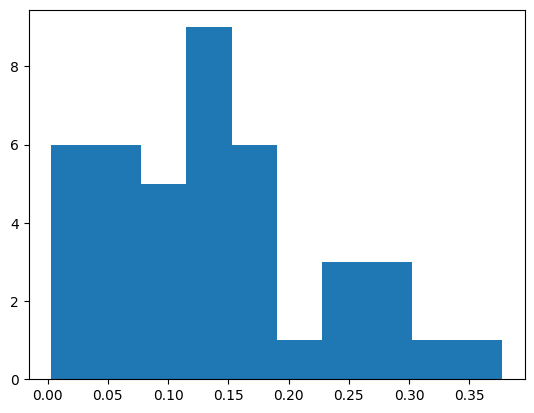

In [136]:
plt.hist(df.error.values);

In [139]:
df.to_json('community_results.json', indent=4)